<a href="https://colab.research.google.com/github/AlbertoB12/AIMeditationCoach/blob/main/fine_tuning_meditation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Install and import packages / Project configuration

In [1]:
# Install packages
!pip install -q -U transformers datasets accelerate bitsandbytes peft trl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 111.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 504.9/504.9 kB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.9/511.9 kB 42.2 MB/s eta 0:00:00


In [2]:
# Imports
import torch, random
from huggingface_hub import login
from datasets import load_dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, TrainingArguments
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training, PeftModel, AutoPeftModelForCausalLM
from trl import SFTTrainer
from google.colab import userdata
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# Get the token from Colab's secret manager
hf_token = userdata.get('hf_token')

# Log in to Hugging Face programmatically
login(token=hf_token)

# 2. Dataset Loading and Preparation

In [4]:
dataset_file = 'Meditation1.json'

# Load dataset
full_dataset = load_dataset('json', data_files=dataset_file, split='train', encoding='UTF-8')

# Shuffle the dataset for randomness
shuffled_dataset = full_dataset.shuffle(seed=42)

# Split the dataset into 90% for training and 10% for validation
split_dataset = shuffled_dataset.train_test_split(test_size=0.1)

# Create a Dataset ditionary to keep the splits
dataset = DatasetDict({
    'train': split_dataset['train'],
    'test': split_dataset['test']
})

print(dataset)

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['instruction', 'input', 'output'],
        num_rows: 759
    })
    test: Dataset({
        features: ['instruction', 'input', 'output'],
        num_rows: 85
    })
})


In [5]:
# This function formats each example into a single string with the required prompt structure
def format_dataset(example):
    text = f"### Instruction:\n{example['instruction']}\n\n### Input:\n{example['input']}\n\n### Output:\n{example['output']}"
    return {"text": text}

# Apply this function to the train and test splits
formatted_train_dataset = dataset['train'].map(format_dataset)
formatted_test_dataset = dataset['test'].map(format_dataset)

Map:   0%|          | 0/759 [00:00<?, ? examples/s]

Map:   0%|          | 0/85 [00:00<?, ? examples/s]

# 3. Model Configuration and Fine-Tuning

Core of the script where the model is configured and the fine-tuning process is executed.

**Model Selection:** It specifies the base model to be fine-tuned, mistralai/Mistral-7B-Instruct-v0.3.

**Quantization:** To run this LLM on the available hardware, 4-bit quantization is used. This reduces the model's memory footprint without a major loss in performance.

**LoRA:** Instead of retraining the entire model, LoRA is used to insert small trainable layers.

**Training Arguments:** Key hyperparameters for the training process are set.

**Training Execution:** The SFTTrainer is initialized with the model, datasets, and training arguments. The trainer.train() command starts the fine-tuning process.

In [6]:
# Model and training configuration
base_model = "meta-llama/Llama-3.2-3B-Instruct"
output_dir = "Llama-3.2-3B-Instruct-MeditationGuide"  # Where to save the new fine-tuned model locally

# Define the name for the model on Hugging Face
hf_model_ID = "AlbertoB12/Llama-3.2-3B-Instruct-MeditationGuide"

# Configure quantization to load the model in 4-bit
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

# Load the base model and Tokenizer
model = AutoModelForCausalLM.from_pretrained(
    base_model,
    quantization_config=bnb_config,  # Apply quantization configuration
    device_map="auto"  # Automatically place layers on GPU/CPU
)

# Load tokenizer and tokenizer options
tokenizer = AutoTokenizer.from_pretrained(base_model)
tokenizer.padding_side = 'right'
tokenizer.pad_token = tokenizer.eos_token

# Configure LoRA
model = prepare_model_for_kbit_training(model)
lora_config = LoraConfig(
    r=64,  # Rank of the update matrices
    lora_alpha=128,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
    # Target the attention modules of the Gemma model
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"]
)
model = get_peft_model(model, lora_config)

# Set training arguments
training_args = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=3,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=1,
    learning_rate=2e-5,
    logging_steps=20,  # Log training loss every 20 steps
    save_strategy="steps",
    eval_strategy="steps",
    eval_steps=20,  # Evaluate every 20 steps
    lr_scheduler_type="cosine",
    warmup_ratio=0.1,
    weight_decay=0.01,
    do_eval=True,
    report_to="none",
    push_to_hub=True,
    hub_model_id=hf_model_ID,
    hub_private_repo=True  # Keep model first private
)

# Initialize the trainer
trainer = SFTTrainer(
    model=model,
    train_dataset=formatted_train_dataset,
    eval_dataset=formatted_test_dataset,
    peft_config=lora_config,
    args=training_args,
)

# Start the fine-tuning
trainer.train()

# Save the final model
print(f"Saving fine-tuned model to '{output_dir}'...")
trainer.save_model(output_dir)
print("Model saved successfully.")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/878 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.46G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/peft/mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/peft/mapping_func.py:79: UserWarning: The PEFT config's `base_model_name_or_path` was renamed from 'meta-llama/Llama-3.2-3B-Instruct' to 'None'. Please ensure that the correct base model is loaded when loading this checkpoint.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/peft/tuners/tuners_utils.py:196: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


Adding EOS to train dataset:   0%|          | 0/759 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/759 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/759 [00:00<?, ? examples/s]

Adding EOS to eval dataset:   0%|          | 0/85 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/85 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/85 [00:00<?, ? examples/s]

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:929: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss,Validation Loss
20,1.153600,0.876237
40,0.721000,0.631542
60,0.612300,0.596391
80,0.593600,0.580543
100,0.573600,0.572651
120,0.564800,0.569232
140,0.568800,0.568439


Saving fine-tuned model to 'Llama-3.2-3B-Instruct-MeditationGuide'...


Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...t-MeditationGuide/training_args.bin: 100%|##########| 6.16kB / 6.16kB            

  ...ruct-MeditationGuide/tokenizer.json: 100%|##########| 17.2MB / 17.2MB            

  ...tionGuide/adapter_model.safetensors:  11%|#         | 41.9MB /  389MB            

No files have been modified since last commit. Skipping to prevent empty commit.


Model saved successfully.


# 4. Results and Evaluation

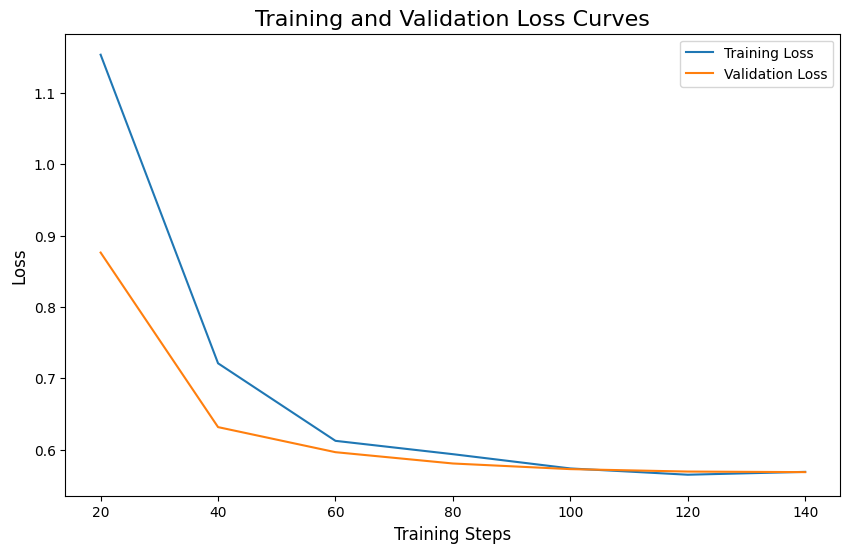

In [7]:
# Plot training and validation loss
# Extract the log history from the trainer
log_history = trainer.state.log_history
df = pd.DataFrame(log_history)

# Separate training and evaluation logs
train_logs = df[df['loss'].notna()].copy()
eval_logs = df[df['eval_loss'].notna()].copy()

# Plot the loss curves
plt.figure(figsize=(10, 6))
plt.plot(train_logs['step'], train_logs['loss'], label='Training Loss')
plt.plot(eval_logs['step'], eval_logs['eval_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Curves', fontsize=16)
plt.xlabel('Training Steps', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.show()

In [11]:
# Inference test
# Authenticate to Huggingface
#hf_token = userdata.get('hf_token')
#login(token=hf_token)

# Set model configuration
base_model_id = "meta-llama/Llama-3.2-3B-Instruct"  # Base model
adapter_id = "AlbertoB12/Llama-3.2-3B-Instruct-MeditationGuide"  # LoRA adapter on Huggingface

# Configure quantization to save memory
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16
)

# Load tokenizer and base model
tokenizer = AutoTokenizer.from_pretrained(base_model_id)
# Load the base model with the quantization
base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,
    quantization_config=bnb_config,
    device_map="auto",  # Use GPU if available
    torch_dtype=torch.float16,
    low_cpu_mem_usage=True,
    trust_remote_code=True
)

# Apply LoRA adapter in the base model
model = PeftModel.from_pretrained(base_model, adapter_id)

# Create the prompt
prompt = f"""### Instruction:
You are a domain expert and content creator for an AI-driven app specializing in meditation and wellness.

### Input:
'intended_outcome': 'focus and clarity',
'session_duration': '5-10 minutes',
'suggested_techniques': 'mindfulness, affirmations',
'system_prompt': 'You are a meditation coach specialized in guiding users through meditation sessions tailored to their emotional states. Your goal is to provide calming, personalized instructions for a variety of emotions, helping users manage feelings like stress, happiness, worry, or anxiety. In your responses, offer grounding techniques, mindfulness practices, breathing exercises, and gentle affirmations to create a comforting and positive environment. Adapt the instructions to each user's emotional context and ensure they feel supported, peaceful, and encouraged to follow your guidance step-by-step.',
'user_experience_level': 'beginner',
'user_prompt': 'Guide me through a mindfulness meditation for anxiety about losing a job.'

### Output:
"""

# Generate response
input_ids = tokenizer(prompt, return_tensors="pt", truncation=True).input_ids.cuda()
outputs = model.generate(
    input_ids=input_ids,
    max_new_tokens=10000,
    do_sample=True,
    temperature=0.7,
    top_k=50,
    top_p=0.95
)

# Decode and print the result
generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
# Split output to get only the new generated part, not the prompt
output = generated_text.split("### Output:")[1].strip()

# Output result
print("\nModel output:")
print(output)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Model output:
Welcome to this mindfulness meditation session. I'm here to support you through this challenging time. Find a quiet and comfortable place to sit or lie down, where you can relax without distractions.

Take a few deep breaths, inhaling through your nose and exhaling through your mouth. Feel the air moving in and out of your body, and allow your breathing to become the focus of your attention.

Now, bring your attention to your physical body. Starting from your toes, bring awareness to each part of your body, moving up to the top of your head. As you focus on each area, release any tension or discomfort, allowing yourself to relax further.

As we proceed, I want you to repeat the following affirmation to yourself: "I am capable and competent, and I will navigate this situation with confidence and clarity." Repeat this phrase to yourself, allowing the words to sink in and become a part of your inner dialogue.

Begin to focus on your breath, noticing the sensation of the air